# **Text Emojifier**

## Setup

In [31]:
import math

from kagglehub import dataset_download
import os
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sb
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import re
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Layer, Input
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention
from tensorflow.python.keras.callbacks import EarlyStopping

In [32]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

device='cuda'


### Dataframe

In [69]:
def get_emojis_df():
    path = dataset_download("hariharasudhanas/twitter-emoji-prediction")

    dataframes = {}
    for dirpath, dirnames, filenames in os.walk(path):
        if "Train.csv" in filenames:
            csv_path = os.path.join(dirpath, "Train.csv")
            dataframes["Dataset"] = pd.read_csv(csv_path).drop(['Unnamed: 0'], axis = 1)
        if "Mapping.csv" in filenames:
            csv_path = os.path.join(dirpath, "Mapping.csv")
            dataframes["Mapping"] = pd.read_csv(csv_path).drop(['Unnamed: 0'], axis = 1)

    if len(dataframes) != 2:
        raise FileNotFoundError("Some files were not found in the specified directories.")

    return dataframes

In [70]:
def mapping_to_dict(mapping):
    emoticons = mapping['emoticons'].tolist()
    mapp = {}
    for emo in range(0, len(emoticons)):
        mapp[emo]= emoticons[emo]
    return mapp

In [71]:
def load_or_compute_df(file_path, function, *args):
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        return joblib.load(file_path)

    print(f"Computing and saving {file_path}...")
    df = function(*args)
    joblib.dump(df, file_path)
    return df

In [72]:
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Remove extra white space from text
    # text = re.sub(r'\W', ' ', str(text))          # Remove all the special characters from text
    # text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)   # Remove all single characters from text
    # text = re.sub(r'[^a-zA-Z\s]', '', text)       # Remove any character that isn't alphabetical
    text = text.lower()

    return text

In [73]:
def delete_emoji(df, emoji_number, mapping):
    df.drop(df[df['Label'] == emoji_number].index, inplace=True)
    mapping[emoji_number] = mapping[len(mapping)-1]
    df['Label'] = df['Label'].apply(lambda x: emoji_number if x == len(mapping)-1 else x)
    del mapping[len(mapping)-1]
    return df, mapping

In [74]:
def unify_emojis(df, emojis_numbers, mapping):
    new_label = emojis_numbers[0]
    for emoji_number in emojis_numbers[1:]:
        df['Label'] = df['Label'].apply(lambda x: new_label if x == emoji_number else x)
        del mapping[emoji_number]
    return df, mapping

In [75]:
def fix_missing(df, mapping):
    keys_sorted = [key for key in mapping.keys()]
    print(keys_sorted, type(keys_sorted))
    for i in range(0, len(mapping)):
        if i not in mapping:
            prev_key = keys_sorted.pop()
            df['Label'] = df['Label'].apply(lambda x: i if x == prev_key else x)
            mapping[i] = mapping[prev_key]
            del mapping[prev_key]
    return df, mapping

In [76]:
def encode_df(df):
    df.dropna(inplace=True)

    df['TEXT processed'] = df['TEXT'].apply(process_text)
    df['TEXT tokenized'] = df['TEXT processed'].apply(lambda x: word_tokenize(x))
    df['TEXT stemmed'] = df['TEXT tokenized'].apply(lambda tokens: [ps.stem(word) for word in tokens if word.isalpha() and word not in stop_words])
    return df

In [77]:
def get_encoded_dfs():
    dfs = get_emojis_df()

    df = dfs['Dataset']
    mapping = mapping_to_dict(dfs['Mapping'])
    for emoji_num in [19, 12, 11, 9, 8, 5]:  # '❤', '💯', '☀', '🎄', '😘', '🇺🇸'
        df, mapping = delete_emoji(df, emoji_num, mapping)
    df, mapping = unify_emojis(df, [1, 6], mapping)  # '📷', '📸'
    df, mapping = unify_emojis(df, [8, 5, 12], mapping)  # '💙', '💕', '💜'
    df, mapping = unify_emojis(df, [10, 0, 4, 11], mapping)  # '😁', '😜', '😉', '😊'
    df, mapping = unify_emojis(df, [7, 9], mapping)  # '🔥', '😎'

    df, mapping = fix_missing(df, mapping)

    df = encode_df(df)

    return df, mapping

In [78]:
df, emoji_mapping = get_encoded_dfs()
# inverse_emoji_mapping = {v: k for k, v in emoji_mapping.items()}

[1, 2, 3, 7, 8, 10, 13] <class 'list'>


### Train, validation, test splitting

In [79]:
def get_split_df(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=0):
    assert (train_ratio + test_ratio + val_ratio) == 1

    train_df = df.sample(frac=train_ratio, random_state=random_state)
    remaining_df = df.drop(train_df.index)

    validation_df = remaining_df.sample(frac=val_ratio / (val_ratio + test_ratio), random_state=random_state)
    test_df = remaining_df.drop(validation_df.index)

    return train_df, validation_df, test_df

In [80]:
train_df, val_df, test_df = get_split_df(df)

### Bag of Words

In [81]:
def get_most_popular_words(df, column, num_words=500):
    print(f"Creating dictionary for {column}...")
    dictionary = {}

    for tokens in df[column]:
        for word in tokens:
                dictionary[word] = dictionary.get(word, 0) + 1

    # Sort and get the top words
    sorted_words = sorted(dictionary.items(), key=lambda item: item[1], reverse=True)
    return [word for word, _ in sorted_words[:num_words]]

In [84]:
top_words = get_most_popular_words(train_df, 'TEXT stemmed')
print(top_words[:15])

Creating dictionary for TEXT stemmed...
['user', 'love', 'new', 'amp', 'day', 'happi', 'thank', 'get', 'time', 'night', 'one', 'today', 'got', 'like', 'york']


In [86]:
def add_bag_of_words(df, column, bag_of_word):
    new_df = df.copy()

    for word in bag_of_word:
        new_df[f'word: {word}'] = new_df[f'{column}'].apply(lambda x: int(x.count(word)))
        new_df[f'word: {word}'] = new_df[f'word: {word}'].astype('float32')
        new_df = new_df.copy()

    return new_df

In [87]:
train_df = load_or_compute_df("train_encoded.joblib", add_bag_of_words, train_df, 'TEXT stemmed', top_words)
val_df = load_or_compute_df("val_encoded.joblib", add_bag_of_words, val_df, 'TEXT stemmed', top_words)
test_df = load_or_compute_df("test_encoded.joblib", add_bag_of_words, test_df, 'TEXT stemmed', top_words)

Computing and saving train_encoded.joblib...
Computing and saving val_encoded.joblib...
Computing and saving test_encoded.joblib...


In [88]:
BOW_FEATURES = [f'word: {word}' for word in top_words]
TARGET = 'Label'

### Model Evaluation

In [89]:
def print_metrics(model_name, y_true, y_pred):
    print(f'/////// {model_name} Evaluation ///////')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f} (weighted)')
    print(f'Recall: {recall:.4f} (weighted)')
    print(f'F1 Score: {f1:.4f} (weighted)')

In [90]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [91]:
def print_model_evaluation(model_name, y_true, y_pred):

    print_metrics(model_name, y_true, y_pred)
    plot_confusion_matrix(y_true, y_pred, emoji_mapping)

    print('\n/////// Detailed Classification Report ///////')
    print(classification_report(baseline_y_test, baseline_y_pred, digits=4))

### Saving Models

In [92]:
TRAINED_MODELS_FOLDER = 'trained_models'

In [93]:
if not os.path.exists(TRAINED_MODELS_FOLDER):
    os.makedirs(TRAINED_MODELS_FOLDER)

In [94]:
def save_model(model, model_name):
    model_save_path = os.path.join(TRAINED_MODELS_FOLDER, model_name)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

## Data Analysis

In [95]:
print('Number of training examples: ', len(train_df))
print('Number of test examples: ', len(test_df))

Number of training examples:  31396
Number of test examples:  6728


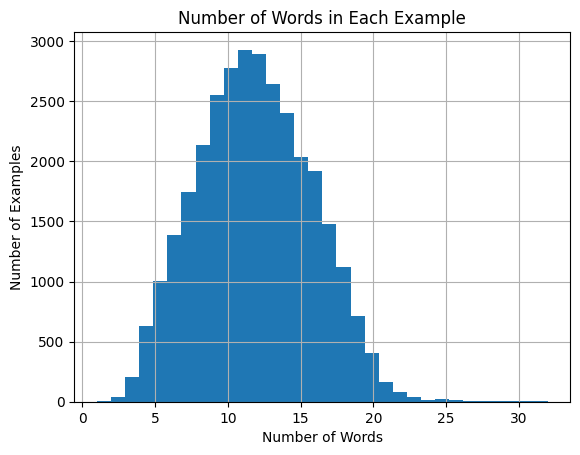

In [100]:
# Histogram of number of words in each example
train_df['TEXT processed'].apply(lambda x: len(x.split())).hist(bins=max(train_df['TEXT processed'].apply(lambda x: len(x.split()))))
plt.xlabel('Number of Words')
plt.ylabel('Number of Examples')
plt.title('Number of Words in Each Example')
plt.show()

In [101]:
# Total number of words in the dataset
total_words = train_df['TEXT tokenized'].apply(lambda x: len(x)).sum()
print('Total number of words in the dataset: ', total_words)

Total number of words in the dataset:  461749


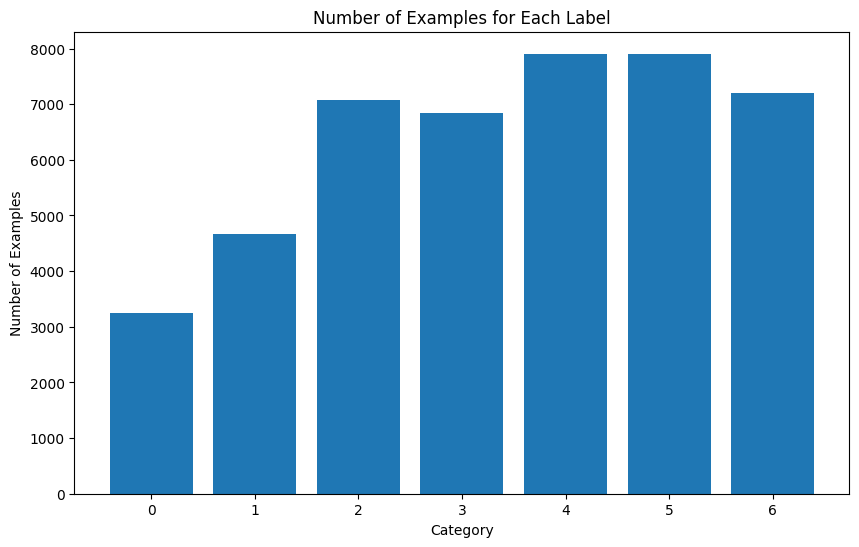

In [102]:
category_counts = df['Label'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)

plt.xlabel('Category')
plt.ylabel('Number of Examples')
plt.title('Number of Examples for Each Label')

plt.xticks(ticks=category_counts.index, labels=category_counts.index)
plt.show()

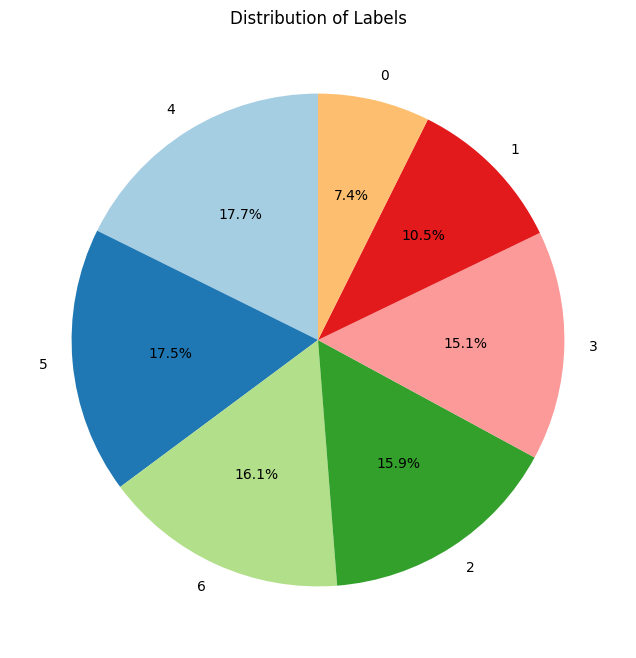

In [103]:
category_counts = train_df['Label'].value_counts()

plt.figure(figsize=(8, 8))  # Adjust the size of the pie chart
plt.pie(
    category_counts.values,
    labels=category_counts.index, # Optional: Use actual emojis
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors  # Optional: Use a colormap for better visuals
)

plt.title('Distribution of Labels')
plt.show()


In [104]:
emoji_mapping

{1: '📸', 2: '😍', 3: '😂', 0: '✨', 4: '😁', 5: '💕', 6: '🔥'}

## Baseline Model

In [106]:
baseline_x_train = pd.concat([train_df[BOW_FEATURES], val_df[BOW_FEATURES]], axis=0)
baseline_y_train = pd.concat([train_df[TARGET], val_df[TARGET]])

baseline_x_test = test_df[BOW_FEATURES]
baseline_y_test = test_df[TARGET]

In [115]:
baseline_model = DummyClassifier(strategy='most_frequent')

In [116]:
print('Training baseline model...')
baseline_model.fit(baseline_x_train, baseline_y_train)

Training baseline model...


DummyClassifier(strategy='most_frequent')

In [117]:
print('Predicting with baseline model...')
baseline_y_pred = baseline_model.predict(baseline_x_test)

Predicting with baseline model...


/////// Baseline Model Evaluation ///////
Accuracy: 0.1758
Precision: 0.0309 (weighted)
Recall: 0.1758 (weighted)
F1 Score: 0.0526 (weighted)


C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


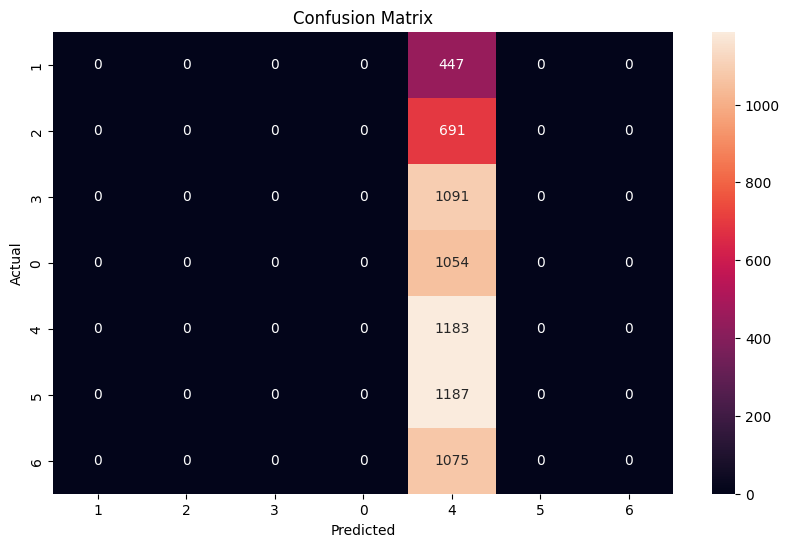


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       447
           1     0.0000    0.0000    0.0000       691
           2     0.0000    0.0000    0.0000      1091
           3     0.0000    0.0000    0.0000      1054
           4     0.1758    1.0000    0.2991      1183
           5     0.0000    0.0000    0.0000      1187
           6     0.0000    0.0000    0.0000      1075

    accuracy                         0.1758      6728
   macro avg     0.0251    0.1429    0.0427      6728
weighted avg     0.0309    0.1758    0.0526      6728



C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [118]:
print_model_evaluation('Baseline Model', baseline_y_test, baseline_y_pred)

## Softmax Model

In [119]:
softmax_x_train = torch.tensor(train_df[BOW_FEATURES[:200]].values, dtype=torch.float32)
softmax_y_train = torch.tensor(train_df[TARGET].values, dtype=torch.float32)

softmax_x_val = torch.tensor(val_df[BOW_FEATURES[:200]].values, dtype=torch.float32)
softmax_y_val = torch.tensor(val_df[TARGET].values, dtype=torch.float32)

softmax_x_test = torch.tensor(test_df[BOW_FEATURES[:200]].values, dtype=torch.float32)
softmax_y_test = torch.tensor(test_df[TARGET].values, dtype=torch.float32)

In [120]:
class SoftmaxModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SoftmaxModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x) # Softmax is included in the loss function

In [121]:
# Model configuration
num_classes = len(emoji_mapping)
input_dim = softmax_x_train.shape[1]
softmax_model = SoftmaxModel(input_dim, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(softmax_model.parameters(), lr=0.01)

In [122]:
# Early Stopping Configuration
patience = 10
min_delta = 1e-4
best_val_loss = float('inf')
early_stop_counter = 0

In [52]:
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    softmax_model.train()

    # Forward pass
    outputs = softmax_model(softmax_x_train)
    loss = criterion(outputs, softmax_y_train.long())  # Ensure labels are integers

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    softmax_model.eval()
    with torch.no_grad():
        val_outputs = softmax_model(softmax_x_val)
        val_loss = criterion(val_outputs, softmax_y_val.long())

    val_losses.append(val_loss.item())

    # Check for early stopping
    if val_loss.item() < best_val_loss - min_delta:
        best_val_loss = val_loss.item()
        early_stop_counter = 0
        torch.save(softmax_model.state_dict(), 'best_softmax_model.pth')
    else:
        early_stop_counter += 1

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
        break

# Load the best model for evaluation
softmax_model.load_state_dict(torch.load('best_softmax_model.pth'))
os.remove('best_softmax_model.pth')

Epoch [50/200], Train Loss: 1.7383, Val Loss: 1.7566
Epoch [100/200], Train Loss: 1.7132, Val Loss: 1.7395
Epoch [150/200], Train Loss: 1.7074, Val Loss: 1.7369
Early stopping triggered at epoch 179. Best validation loss: 1.7366


C:\Users\Chaim\AppData\Local\Temp\ipykernel_12664\2439864243.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  softmax_model.load_state_dict(torch.load('best_softmax_mode

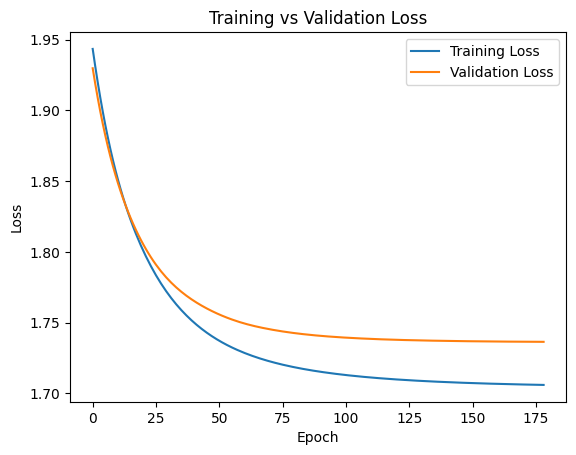

In [53]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

/////// Softmax Model Evaluation ///////
Accuracy: 0.3129
Precision: 0.3127 (weighted)
Recall: 0.3129 (weighted)
F1 Score: 0.3037 (weighted)


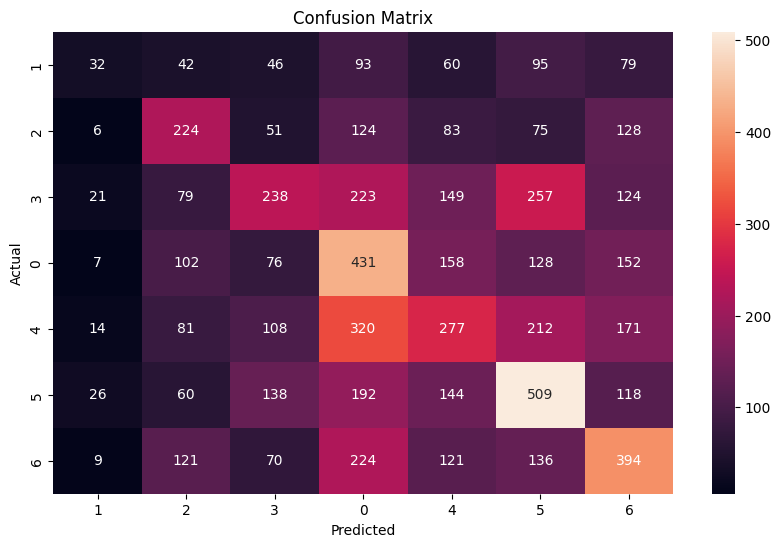


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       447
           1     0.0000    0.0000    0.0000       691
           2     0.0000    0.0000    0.0000      1091
           3     0.0000    0.0000    0.0000      1054
           4     0.1758    1.0000    0.2991      1183
           5     0.0000    0.0000    0.0000      1187
           6     0.0000    0.0000    0.0000      1075

    accuracy                         0.1758      6728
   macro avg     0.0251    0.1429    0.0427      6728
weighted avg     0.0309    0.1758    0.0526      6728



C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [54]:
softmax_model.eval()
with torch.no_grad():
    test_outputs = softmax_model(softmax_x_test)
    softmax_y_pred = torch.argmax(test_outputs, dim=1)
print_model_evaluation('Softmax Model', softmax_y_test, softmax_y_pred)

In [55]:
save_model(softmax_model, 'softmax_model.pth')

Model saved to trained_models\softmax_model.pth


## Basic Neural Network

In [56]:
train_dataset = TensorDataset(torch.tensor(train_df[BOW_FEATURES].values, dtype=torch.float32),
                               torch.tensor(train_df[TARGET].values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_df[BOW_FEATURES].values, dtype=torch.float32),
                             torch.tensor(val_df[TARGET].values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_df[BOW_FEATURES].values, dtype=torch.float32),
                              torch.tensor(test_df[TARGET].values, dtype=torch.float32))

In [57]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

In [58]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, output_size)  # No activation, raw logits for CrossEntropyLoss
        )

    def forward(self, x):
        return self.network(x)

In [59]:
# Model configuration
num_classes = len(emoji_mapping)
input_dim = train_df[BOW_FEATURES].shape[1]
simple_nn_model = SimpleNN(input_dim, num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_nn_model.parameters(), lr=0.001, weight_decay=1e-4)

In [61]:
# Early Stopping Configuration
patience = 10
min_delta = 1e-4
best_val_loss = float('inf')
early_stop_counter = 0

In [62]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    simple_nn_model.train()
    running_train_loss = 0.0  # Accumulate training loss
    for inputs, targets in train_loader:
        # Forward pass
        outputs = simple_nn_model(inputs)
        loss = criterion(outputs, targets.long())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    simple_nn_model.eval()
    running_val_loss = 0.0  # Accumulate validation loss
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = simple_nn_model(val_inputs)
            val_loss = criterion(val_outputs, val_targets.long())
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(simple_nn_model.state_dict(), 'best_simple_nn_model.pth')
    else:
        early_stop_counter += 1

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    if early_stop_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
        break

# Load the best model for evaluation
simple_nn_model.load_state_dict(torch.load('best_simple_nn_model.pth'))
os.remove('best_simple_nn_model.pth')

Epoch [1/50], Train Loss: 1.8779, Val Loss: 1.7903
Epoch [2/50], Train Loss: 1.7908, Val Loss: 1.7441
Epoch [3/50], Train Loss: 1.7659, Val Loss: 1.7255
Epoch [4/50], Train Loss: 1.7423, Val Loss: 1.7209
Epoch [5/50], Train Loss: 1.7348, Val Loss: 1.7125
Epoch [6/50], Train Loss: 1.7250, Val Loss: 1.7099
Epoch [7/50], Train Loss: 1.7161, Val Loss: 1.7008
Epoch [8/50], Train Loss: 1.7083, Val Loss: 1.7034
Epoch [9/50], Train Loss: 1.7028, Val Loss: 1.6976
Epoch [10/50], Train Loss: 1.6978, Val Loss: 1.6976
Epoch [11/50], Train Loss: 1.6933, Val Loss: 1.6976
Epoch [12/50], Train Loss: 1.6894, Val Loss: 1.6989
Epoch [13/50], Train Loss: 1.6859, Val Loss: 1.6992
Epoch [14/50], Train Loss: 1.6819, Val Loss: 1.6934
Epoch [15/50], Train Loss: 1.6798, Val Loss: 1.6943
Epoch [16/50], Train Loss: 1.6742, Val Loss: 1.6969
Epoch [17/50], Train Loss: 1.6705, Val Loss: 1.6984
Epoch [18/50], Train Loss: 1.6692, Val Loss: 1.6964
Epoch [19/50], Train Loss: 1.6646, Val Loss: 1.6968
Epoch [20/50], Train 

C:\Users\Chaim\AppData\Local\Temp\ipykernel_12664\4287012924.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simple_nn_model.load_state_dict(torch.load('best_simple_nn_

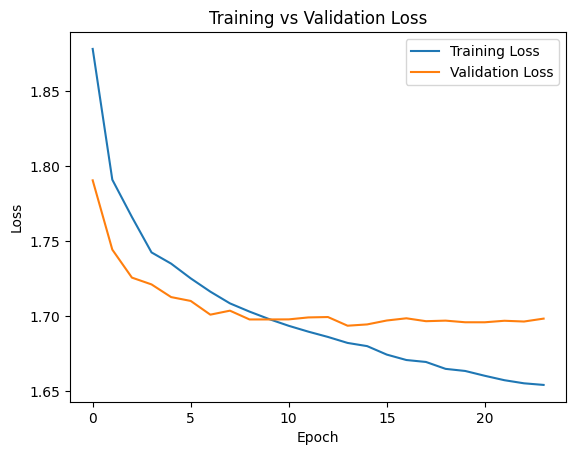

In [63]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

/////// SimpleNN Model Evaluation ///////
Accuracy: 0.3359
Precision: 0.3338 (weighted)
Recall: 0.3359 (weighted)
F1 Score: 0.3242 (weighted)


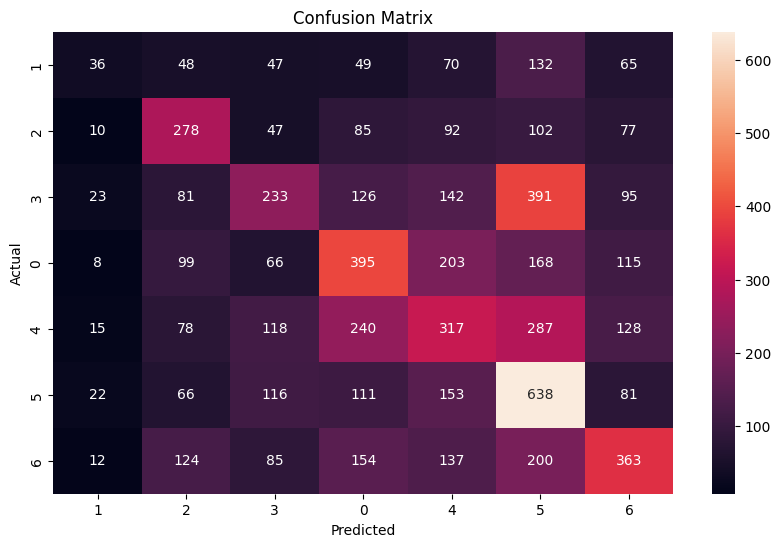


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       447
           1     0.0000    0.0000    0.0000       691
           2     0.0000    0.0000    0.0000      1091
           3     0.0000    0.0000    0.0000      1054
           4     0.1758    1.0000    0.2991      1183
           5     0.0000    0.0000    0.0000      1187
           6     0.0000    0.0000    0.0000      1075

    accuracy                         0.1758      6728
   macro avg     0.0251    0.1429    0.0427      6728
weighted avg     0.0309    0.1758    0.0526      6728



C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [65]:
simple_nn_model.eval()
all_preds = []

with torch.no_grad():
    for test_inputs, _ in test_loader:  # Use test_loader for batch processing
        test_outputs = simple_nn_model(test_inputs)
        batch_preds = torch.argmax(test_outputs, dim=1)
        all_preds.append(batch_preds)
simple_nn_y_pred = torch.cat(all_preds)

print_model_evaluation('SimpleNN Model', test_df[TARGET].values, simple_nn_y_pred.cpu().numpy())

In [66]:
save_model(simple_nn_model, 'simple_nn_model.pth')

Model saved to trained_models\simple_nn_model.pth


## LSTM with Embeddings

### Word Embeddings

In [78]:
f = open("glove.twitter.27B/glove.twitter.27B.200d.txt", encoding='utf8')
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    emb = np.array(values[1:], dtype='float')
    embedding_index[word] = emb
embedding_dim = embedding_index['hello'].shape[0]

In [79]:
embedding_index['user']

array([ 4.2766e-01,  2.4532e-01, -8.4922e-01,  3.1648e-01,  1.6538e-01,
       -5.8628e-01,  8.5115e-01,  6.3838e-03,  6.5366e-02, -7.1155e-01,
       -2.2464e-01, -1.3552e-01, -1.5848e-01, -1.0465e+00, -2.5073e-01,
       -3.2956e-01,  5.8865e-01,  7.2249e-02,  1.4451e-01, -1.7732e-01,
       -1.0752e-03,  1.0197e-01,  7.3183e-02,  3.2360e-01, -8.7387e-01,
       -1.0808e+00,  3.3931e-01, -1.1672e-01,  1.0462e-01,  1.0419e+00,
        3.6597e-01,  2.0681e-02,  1.3460e-01, -9.4696e-01, -2.3978e-02,
       -8.2389e-01,  9.6535e-02, -1.3870e-01, -5.2832e-01,  3.9776e-01,
       -8.4624e-01,  4.7066e-01, -2.5022e-01,  7.7712e-01, -4.3216e-01,
        6.6454e-02, -3.5458e-01, -4.9915e-01,  2.3011e-01,  1.0778e-01,
       -1.4022e-01,  5.0438e-01, -5.8577e-01, -2.7001e-01,  1.9374e-01,
        4.2087e-01,  1.4654e-02,  1.0986e+00, -8.2837e-01, -8.0830e-01,
        1.5268e-02, -7.7748e-01,  8.1273e-01,  3.4014e-01,  3.3876e-01,
        5.4724e-02,  2.0892e-01,  3.0737e-01,  1.4706e-01,  4.24

In [99]:
def get_embedding_output(X_tokenized, embedding_dim, max_sequence_len=20, padding_value=0.0):
    """
    Convert tokenized text data into embedding vectors with padding.

    Args:
    X_tokenized (list of lists): Tokenized text, where each sample is a list of tokens.
    max_sequence_len (int): Maximum number of tokens per sequence.
    padding_value (float): Value to use for padding shorter sequences.

    Returns:
    np.ndarray: Array of shape (num_samples, max_sequence_len, embedding_dim=50).
    """
    embedding_output = np.full((len(X_tokenized), max_sequence_len, embedding_dim), padding_value, dtype=np.float32)

    for ix, tokens in enumerate(X_tokenized):
        for ij, token in enumerate(tokens[:max_sequence_len]):
            embedding_vector = embedding_index.get(token.lower())
            if embedding_vector is not None:
                embedding_output[ix][ij] = embedding_vector

    return embedding_output

In [100]:
max_sequence_len = 20
x_embed = get_embedding_output(df['TEXT tokenized'], embedding_dim, max_sequence_len)
y_one_hot = keras.utils.to_categorical(df[TARGET])

In [101]:
print(f"{x_embed.shape=}, {y_one_hot.shape=}")

x_embed.shape=(44852, 20, 200), y_one_hot.shape=(44852, 7)


In [102]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_embed, y_one_hot, test_size = 0.2)

### Model

In [103]:
model = Sequential()
model.add(Bidirectional(LSTM(units=512, return_sequences=True), input_shape=(max_sequence_len, embedding_dim)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=256)))
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=len(emoji_mapping), activation='softmax'))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional)      │ (None, 20, 1024)            │       2,920,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 512)                 │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,620,167 (21.44 MB)

 Trainable params: 5,620,167 (21.44 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [ ]:
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, batch_size=64, epochs=10,
                 callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

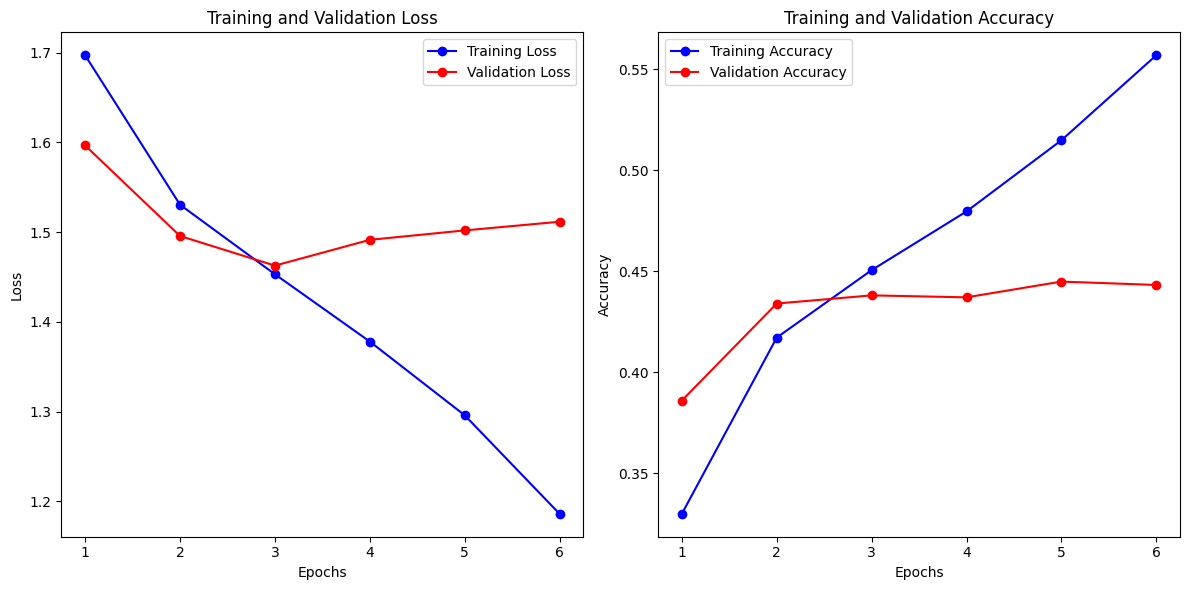

In [88]:
history = hist.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Create epochs array
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [89]:
model.evaluate(x_test, y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4415 - loss: 1.4524


[1.4510482549667358, 0.44342881441116333]

281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step
/////// Bidirectional LSTM Model Evaluation ///////
Accuracy: 0.4434
Precision: 0.4476 (weighted)
Recall: 0.4434 (weighted)
F1 Score: 0.4389 (weighted)


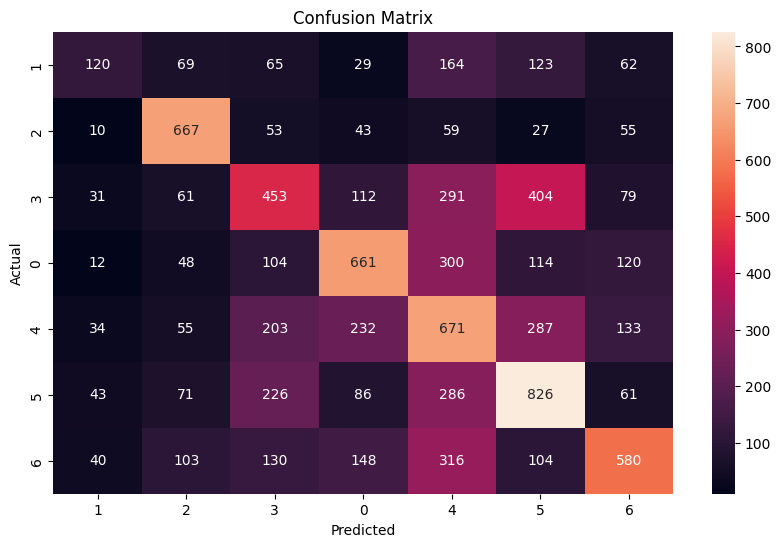


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       447
           1     0.0000    0.0000    0.0000       691
           2     0.0000    0.0000    0.0000      1091
           3     0.0000    0.0000    0.0000      1054
           4     0.1758    1.0000    0.2991      1183
           5     0.0000    0.0000    0.0000      1187
           6     0.0000    0.0000    0.0000      1075

    accuracy                         0.1758      6728
   macro avg     0.0251    0.1429    0.0427      6728
weighted avg     0.0309    0.1758    0.0526      6728



C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [90]:
# Make predictions on the test set
y_pred_proba = model.predict(x_test)  # Predict probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class indices

# Convert true labels to class indices if they are one-hot encoded
y_true = np.argmax(y_test, axis=1)

# Print evaluation results
print_model_evaluation('Bidirectional LSTM Model', y_true, y_pred)


In [94]:
model.save('trained_models/lstm_model.keras')

### Attention

In [133]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weights',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1,),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Score computation
        e = K.tanh(K.dot(x, self.W) + self.b)
        # Convert scores to probabilities
        alpha = K.softmax(e, axis=1)
        # Context vector as weighted sum of input sequences
        context = K.sum(alpha * x, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [177]:
model = Sequential()
model.add(Input(shape=(max_sequence_len, embedding_dim)))
model.add(Bidirectional(LSTM(units=512, recurrent_dropout=0.3, return_sequences=True)))
model.add(SeqSelfAttention())
model.add(Bidirectional(LSTM(units=256, recurrent_dropout=0.3)))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=len(emoji_mapping), activation='softmax'))
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_35 (Bidirectional)     │ (None, 20, 1024)            │       2,920,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ seq_self_attention_9                 │ (None, 20, 1024)            │          65,601 │
│ (SeqSelfAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_36 (Bidirectional)     │ (None, 512)                 │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,685,768 (21.69 MB)

 Trainable params: 5,685,768 (21.69 MB)

 Non-trainable params: 0 (0.00 B)

In [178]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [180]:
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True, batch_size=256, epochs=15,
                 callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 101s 849ms/step - accuracy: 0.2413 - loss: 1.8424 - val_accuracy: 0.3745 - val_loss: 1.6142
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 139s 825ms/step - accuracy: 0.3890 - loss: 1.6020 - val_accuracy: 0.4074 - val_loss: 1.5335
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 142s 825ms/step - accuracy: 0.4222 - loss: 1.5299 - val_accuracy: 0.4206 - val_loss: 1.5029
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 93s 827ms/step - accuracy: 0.4442 - loss: 1.4761 - val_accuracy: 0.4368 - val_loss: 1.4699
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 94s 834ms/step - accuracy: 0.4626 - loss: 1.4332 - val_accuracy: 0.4445 - val_loss: 1.4654
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 140s 819ms/step - accuracy: 0.4856 - loss: 1.3874 - val_accuracy: 0.4399 - val_loss: 1.4791
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 143s 831ms/step - accuracy: 0.5013 - loss: 1.3434 - val_accuracy: 0.4432 - val_loss: 1.4842
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 93s 826ms/step - accuracy: 0.5133 - lo

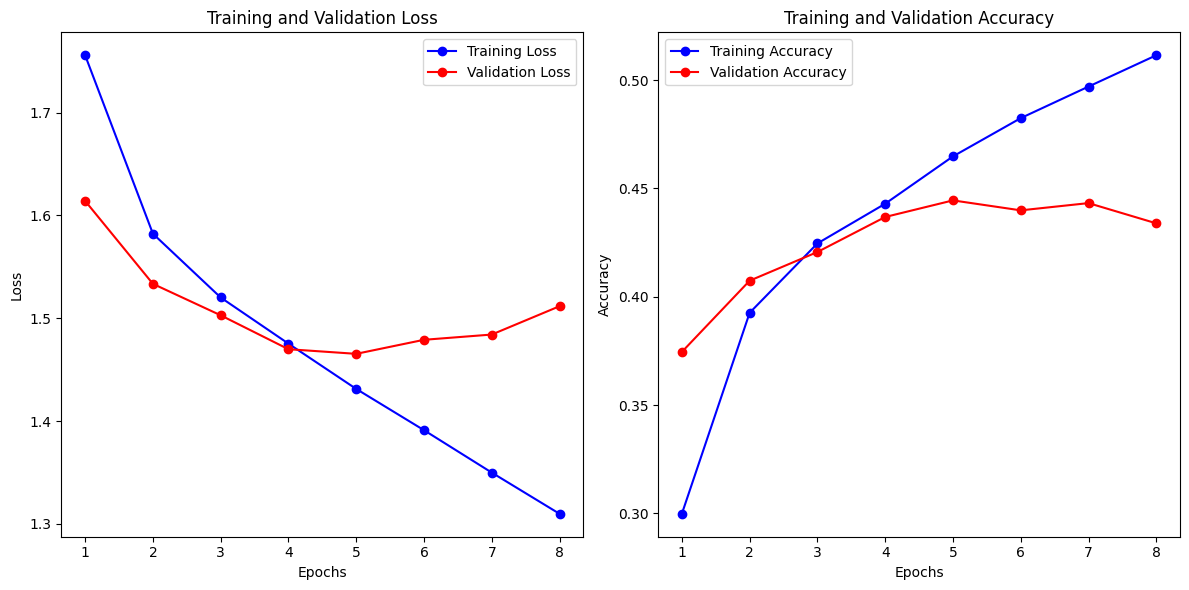

In [181]:
history = hist.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Create epochs array
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [182]:
model.evaluate(x_test, y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.4386 - loss: 1.4823


[1.4715230464935303, 0.44420912861824036]

281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
/////// Bidirectional LSTM Attention Model Evaluation ///////
Accuracy: 0.4352
Precision: 0.4424 (weighted)
Recall: 0.4352 (weighted)
F1 Score: 0.4263 (weighted)


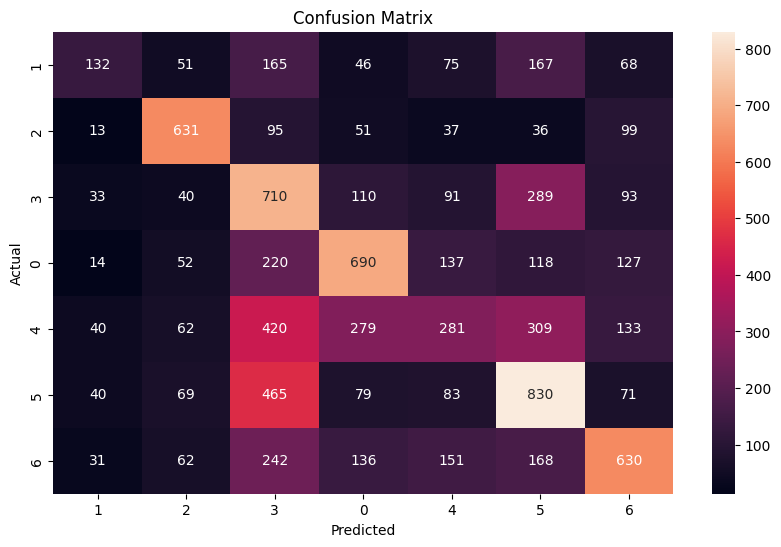


/////// Detailed Classification Report ///////
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       447
           1     0.0000    0.0000    0.0000       691
           2     0.0000    0.0000    0.0000      1091
           3     0.0000    0.0000    0.0000      1054
           4     0.1758    1.0000    0.2991      1183
           5     0.0000    0.0000    0.0000      1187
           6     0.0000    0.0000    0.0000      1075

    accuracy                         0.1758      6728
   macro avg     0.0251    0.1429    0.0427      6728
weighted avg     0.0309    0.1758    0.0526      6728



C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [152]:
# Make predictions on the test set
y_pred_proba = model.predict(x_test)  # Predict probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class indices

# Convert true labels to class indices if they are one-hot encoded
y_true = np.argmax(y_test, axis=1)

# Print evaluation results
print_model_evaluation('Bidirectional LSTM Attention Model', y_true, y_pred)

In [140]:
model.save('trained_models/lstm_model_attention.keras')

## Examples

In [420]:
from tensorflow.keras.models import load_model

model = load_model('lstm_model_attention.keras', custom_objects={'Attention': Attention})

In [422]:
print(mapping)

{1: '📸', 2: '😍', 3: '😂', 7: '🔥', 8: '💕', 10: '😁', 13: '✨'}


In [441]:
examples = [
    'I had an amazing weekend with my friends',
    'My vacation is coming up soon',
    'Yoav had a great time at the party',
    'I cannot believe this had just happened',
    'Magic is in the air',
    'I had a lovely time around the city',
    'I am so excited for the concert tonight',
    'The birthday party was a blast',
]

In [442]:
def tokenize_examples(examples):
    processed = [process_text(example) for example in examples]
    tokenized = [word_tokenize(example) for example in processed]
    return tokenized

tokenized_examples = tokenize_examples(examples)

In [443]:
x_examples = get_embedding_output(tokenized_examples, max_sequence_len=20)

# Predict
predictions = model.predict(x_examples)
predicted_classes = predictions.argmax(axis=1)

# Map predicted classes to emojis (assuming emoji_mapping is a dictionary)
predicted_emojis = [emoji_mapping[class_idx] for class_idx in predicted_classes]

# Display examples and predictions
for example, emoji in zip(examples, predicted_emojis):
    print(f"Example: {example}")
    print(f"Predicted Emoji: {emoji}")
    print("-" * 40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Example: I had an amazing weekend with my friends
Predicted Emoji: 😍
----------------------------------------
Example: My vacation is coming up soon
Predicted Emoji: 😁
----------------------------------------
Example: Yoav had a great time at the party
Predicted Emoji: 😁
----------------------------------------
Example: I cannot believe this had just happened
Predicted Emoji: 😂
----------------------------------------
Example: Magic is in the air
Predicted Emoji: ✨
----------------------------------------
Example: I had a lovely time around the city
Predicted Emoji: 😍
----------------------------------------
Example: I am so excited for the concert tonight
Predicted Emoji: 😁
----------------------------------------
Example: The birthday party was a blast
Predicted Emoji: 🔥
----------------------------------------
